In [1]:
import sys

# 推奨された方法ではない。
# 参照:https://note.com/iamhacchin/n/n8eb3efafadf9
sys.path.append("..")
from scripts.robot import *
from scipy.stats import multivariate_normal


パーティクルに与えるノイズを以下の３つの標準偏差をパラメータとして調整できるものとする。

$$
\sigma_{\nu\nu} : 直進1[m]で生じる道のりのばらつきの標準偏差
$$
$$
\sigma_{\nu\omega} : 回転1[deg]で生じる道のりのばらつきの標準偏差
$$
$$
\sigma_{\omega\nu} : 直進1[m]で生じる向きのばらつきの標準偏差
$$
$$
\sigma_{\omega\omega} : 回転1[deg]で生じる向きのばらつきの標準偏差
$$

上記のパラメータを$\sigma_{ab}$と一般化すると、bがaに与えるばらつきの標準偏差を表していることになる。あとからシミュレーター内でロボットを走らせてこれらの値を計測し、MCLで利用することとする。

$\sigma_{ab}$の値を求める前に、パーティクルを動かす速度、角速度にこれらのパラメータの入力にしたがってノイズをのせるコードを考えてみる。移動量あたりのノイズを速度あたりのノイズに変換しないと行けないので少し計算がいる。まず次のように上で定義した４つの標準偏差に対応する４つのノイズの大きさをドローする。

$$
式(5.9) \delta_{ab} \sim \Nu(0,\sigma^2_{ab})
$$

平均0,分散$\sigma^2_{ab}$の正規分布から値をドローする。

ドローされた値は1[m],1[rad]移動した場合のノイズの量を意味する。

In [2]:
class Particle:
    def __init__(self, init_pose):
        # パーティクルは、今は姿勢情報だけを持つ
        self.pose = init_pose

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        """式(5.5)に相当

        Args:
            nu (_type_): _description_
            omega (_type_): _description_
            time (_type_): _description_
            noise_rate_pdf (_type_): _description_
        """
        # 式(5,9)の実行.ノイズの大きさを取得
        ns = noise_rate_pdf.rvs()
        # 以下2行で式(5.12)を実行
        noised_nu = (
            nu
            + ns[0] * math.sqrt(abs(nu) / time)
            + ns[1] * math.sqrt(abs(omega) / time)
        )
        noised_omega = (
            omega
            + ns[2] * math.sqrt(abs(nu) / time)
            + ns[3] * math.sqrt(abs(omega) / time)
        )

        # ノイズを加えた速度、角速度をstate_transitionに入力し、姿勢を更新
        self.pose = IdealRobot.state_transition(
            noised_nu, noised_omega, time, self.pose
        )


In [3]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds):
        # 初期位置が同じパーティクルobjectをnum個生成
        self.particles = [Particle(init_pose) for i in range(num)]

        # motion_noise_stdsは式(5.9)のσabに対応する
        v = motion_noise_stds
        # np.diagは与えられたリストの要素を対角成分に持つ対角行列を作って返す。
        c = np.diag([v["nn"] ** 2, v["no"] ** 2, v["on"] ** 2, v["oo"] ** 2])
        # 式(5.9)用の正規分布を用意。共分散行列のみ与える。平均はデフォルト0なのでそのまま。
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)

    def motion_update(self, nu, omega, time):
        # 各パーティクルのmotion_updateメソッドを呼び出す
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)

    def draw(self, ax, elems):
        # particleのx座標
        xs = [p.pose[0] for p in self.particles]
        # particleのy座標
        ys = [p.pose[1] for p in self.particles]
        # particleの向きを矢印として描画するための要素x,y
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]

        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))


In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega

    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)


In [5]:
# パーティクルの姿勢が更新されていることを確認
initial_pose = np.array([0, 0, 0]).T  ###mcl5_test（下の出力の先頭数行を記載）
estimator = Mcl(
    initial_pose,
    100,
    motion_noise_stds={"nn": 0.01, "no": 0.02, "on": 0.03, "oo": 0.04},
)
a = EstimationAgent(0.1, 0.2, 10.0 / 180 * math.pi, estimator)
estimator.motion_update(0.2, 10.0 / 180 * math.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[0.02007665 0.0002935  0.0292359 ]
[0.02016425 0.00013516 0.01340551]
[0.02026078 0.00016338 0.01612712]
[0.02128777 0.00020199 0.01897625]
[0.01683016 0.00013485 0.01602407]
[0.02286305 0.00015838 0.01385458]
[0.01672156 0.00015062 0.01801412]
[0.0162044 0.0001421 0.0175375]
[0.01721435 0.00022981 0.02669836]
[0.01722812 0.00021777 0.02527957]
[0.02161113 0.00021079 0.01950711]
[0.02054324 0.00013579 0.01322003]
[0.01842136 0.00023272 0.02526498]
[0.01733096 0.00020943 0.02416707]
[0.01735861 0.00016269 0.01874418]
[0.01991493 0.00010853 0.01089919]
[0.02274282 0.00021576 0.01897302]
[0.02029983 0.00012388 0.01220508]
[0.01883712 0.00018654 0.01980532]
[0.01938482 0.00023738 0.02449025]
[0.01842681 0.00011968 0.01298955]
[0.02057478 0.00031745 0.03085599]
[0.01622016 0.00019461 0.02399511]
[1.88073852e-02 9.31060639e-05 9.90093011e-03]
[0.01592641 0.0002603  0.03268473]
[0.0227319  0.00029608 0.0260483 ]
[0.01562966 0.00016172 0.02069333]
[0.01940268 0.00016967 0.01748853]
[0.01824093

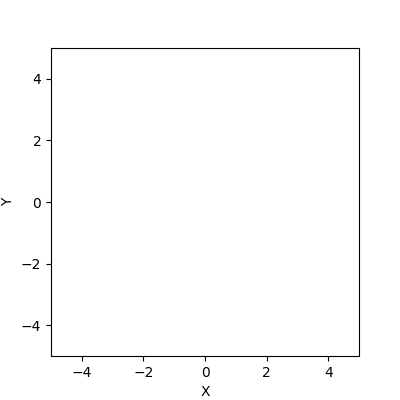

In [6]:
def trial(motion_noise_stds):
    time_interval=0.1
    world = World(30, time_interval)

    initial_pose = np.array([0,0,0]).T
    estimator=Mcl(initial_pose, 100, motion_noise_stds)
    circling=EstimationAgent(time_interval, 0.2, 10/180*math.pi, estimator)
    r = Robot(initial_pose,sensor=None, agent=circling, color="red")
    world.append(r)

    %matplotlib widget
    world.draw()

trial({"nn":0.01,"no":0.02,"on":0.03,"oo":0.04})


エージェントはロボットの真の姿勢を知らない